In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.special import legendre
import matplotlib.pyplot as plt


In [2]:
class AtTemp:
    """
    Represents a system at a specific temperature with properties relevant to eigenvalue calculations.
    
    Attributes:
        a (float): Parameter 'a' affecting the system's behavior.
        N (int): The number of points or elements considered in the system.
        omega_0 (float): A fundamental frequency of the system.
        matsubara (int): The number of Matsubara frequencies to consider.
        ng2 (float): A parameter related to the system's interaction strength.
        T (float): The temperature of the system.
    """

    def __init__(self, a, N, omega_0, matsubara, ng2, T):
        """
        Initializes the AtTemp instance with specified parameters and calculates initial properties.
        """
        self.a = a
        self.N = N
        self.omega_0 = omega_0
        self.matsubara = matsubara
        self.ng2 = ng2
        self.T = T
        self.omega = self.omega_matsu()
        self.lambda_iso = self.val_lambda()
        self.theta = self.theta_array()
        self.zz = self.Z()
        self.integration = self.phi_integration_simpson()
        self.matrix = self.cal_matrix()
        self.eigenvalues = self.eigenvalue_prob()
        self.largest_eigenvalue = self.max_eigenvalue()

    def omega_matsu(self):
        """
        Calculates the Matsubara frequencies for the system.
        
        Returns:
            np.ndarray: Array of Matsubara frequencies.
        """
        omega = np.asarray([(2 * (-(self.matsubara/2) + i) + 1) * np.pi * self.T for i in range(self.matsubara)]) # matsubara frequencies
        return omega
    
    def val_lambda(self):
        lambda_iso = np.asarray(
            [
                [
                    2
                    * self.omega_0
                    * self.ng2
                    / (np.square(self.omega[i] - self.omega[j]) + np.square(self.omega_0))
                    for j in range(len(self.omega))
                ]
                for i in range(len(self.omega))
            ]
        )
        #print('lambdaa', np.max(lambda_iso))
        return lambda_iso
    
    def theta_array(self):
        theta = np.linspace(0, np.pi, self.matsubara)
        return theta
    
    def Z(self):
        sigma_n = np.sum((self.omega / np.abs(self.omega)) * self.lambda_iso, axis=1)
        matrix = np.zeros((len(self.theta), len(sigma_n)))
        for i in range(len(self.theta)):
            legendre_val = legendre(self.N)(np.cos(self.theta[i]))
            for j in range(len(sigma_n)):
                matrix[i, j] = 1 + (np.pi*self.T/(self.omega[j])) * (1 + self.a * legendre_val) * sigma_n[j]
        return matrix

    def phi_integration_simpson(self):
        Zz = self.zz
        integration_list = []
        for i in range(Zz.shape[1]):
            denominator = Zz[:, i]
            numerator = (1 + self.a * (legendre(self.N)(np.cos(self.theta))) )**2 
            sub_integrand = np.divide(numerator, denominator) # for this step we know it will work when len(thera) = len(omega). But what when it doesn't?
            integrand = np.sin(self.theta) * sub_integrand
            integrated_element = integrate.simpson(integrand, self.theta)
            integration_list.append(integrated_element)
        integration = np.array(integration_list)
        return integration
        
    def cal_matrix(self):
        k_matrix = (np.pi/2) * self.T * self.lambda_iso * self.integration
        matrix = np.divide(k_matrix, np.abs(self.omega))
        return matrix
    
    def eigenvalue_prob(self):
        eigenvalues, _ = np.linalg.eig(self.matrix)
        return eigenvalues
    
    def max_eigenvalue(self):
        return np.max(self.eigenvalues)
    
    def t_iter_update(self, T_new):
        self.T = T_new
        self.omega = self.omega_matsu()
        self.lambda_iso = self.val_lambda()
        self.zz = self.Z()
        self.integration = self.phi_integration_simpson()
        self.matrix = self.cal_matrix()
        self.eigenvalues = self.eigenvalue_prob()
        updated_eigenvalue = self.max_eigenvalue()
        return updated_eigenvalue

In [3]:
class ForAvalue(AtTemp):
    """
    Extends AtTemp to iteratively calculate and evaluate eigenvalues over a range of temperatures 
    until a specified eigenvalue limit is exceeded.
    
    Attributes:
        eignevalue_limit (float): The target eigenvalue limit for iteration.
        T_start (float): The starting temperature for the iteration.
        T_steps (float): The temperature increment for each iteration step.
    """
    def __init__(self, a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps):
        """
        Initializes the ForAvalue instance with specific system parameters and iteration settings.
        """
        super().__init__(a, N, omega_0, matsubara, ng2, T_start) # initialize the parent class
        self.eignevalue_limit = eignevalue_limit
        self.T_start = T_start
        self.T_steps = T_steps
        self.T_values, self.eigenvalues_forT = self.iter_over_t()

    def iter_over_t(self):
        """
        Iterates over temperatures, updating the system's state and calculating eigenvalues 
        until the largest eigenvalue exceeds the specified limit.
        
        Returns:
            tuple: A tuple containing two lists, the first of temperature values and the second of corresponding largest eigenvalues.
        """
        eigenvalues_forT = []
        T_values = []
        T = self.T_start
        eigenvalues_forT.append(self.largest_eigenvalue)
        T_values.append(T)
        if self.largest_eigenvalue > self.eignevalue_limit:
            while self.largest_eigenvalue > self.eignevalue_limit:
                T += self.T_steps
                self.largest_eigenvalue = self.t_iter_update(T_new=T)
                eigenvalues_forT.append(self.largest_eigenvalue)
                #print(f'T: {T}, eigenvalue: {self.largest_eigenvalue}')
                T_values.append(T)
        else:
                print("The eigenvalue is already smaller than 1")

        return T_values, eigenvalues_forT # please note, self.eigevalues has already been used in the parent class so you might want to change this name

In [4]:
class ExploreEigenvalue:
    def __init__(self, a_values, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps):
        self.a_values = a_values
        self.N = N
        self.omega_0 = omega_0
        self.matsubara = matsubara
        self.ng2 = ng2
        self.eignevalue_limit = eignevalue_limit
        self.T_start = T_start
        self.T_steps = T_steps
        self.data = self.iter_over_a()
        
    def iter_over_a(self):
        parent_dict = {}
        for a in self.a_values:
            a_value_data = ForAvalue(a, self.N, self.omega_0, self.matsubara, self.ng2, self.eignevalue_limit, self.T_start, self.T_steps)
            nested_dict = {}
            nested_dict['T_values'] = a_value_data.T_values
            nested_dict['eigenvalues'] = a_value_data.eigenvalues_forT
            parent_dict[a] = nested_dict
            
        return parent_dict

In [5]:
omega_0 = 0.05 # phonon frequency
ng2 = 0.014 # coupling strength?

#T = 0.00014
matsubara = 1000
N = 2

eignevalue_limit = 0.97
T_start = 0.0023
T_steps = 0.00001

In [6]:
#a = [-0.3, -0.2, -0.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
a=[0.0]


In [7]:
lessdo = ExploreEigenvalue(a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps)

In [9]:
parent_dict = lessdo.data

In [10]:
import json

# Assuming 'parent_dict' is your nested dictionary
#data_to_save = parent_dict

# Iterate through each 'a' in the parent dictionary
for a, data in parent_dict.items():
    # Replace each complex eigenvalue with its real part
    data['eigenvalues'] = [e.real for e in data['eigenvalues']]

# Serialize and save to a JSON file
with open('eigenvalues_data.json', 'w') as file:
    json.dump(parent_dict, file, indent=4)

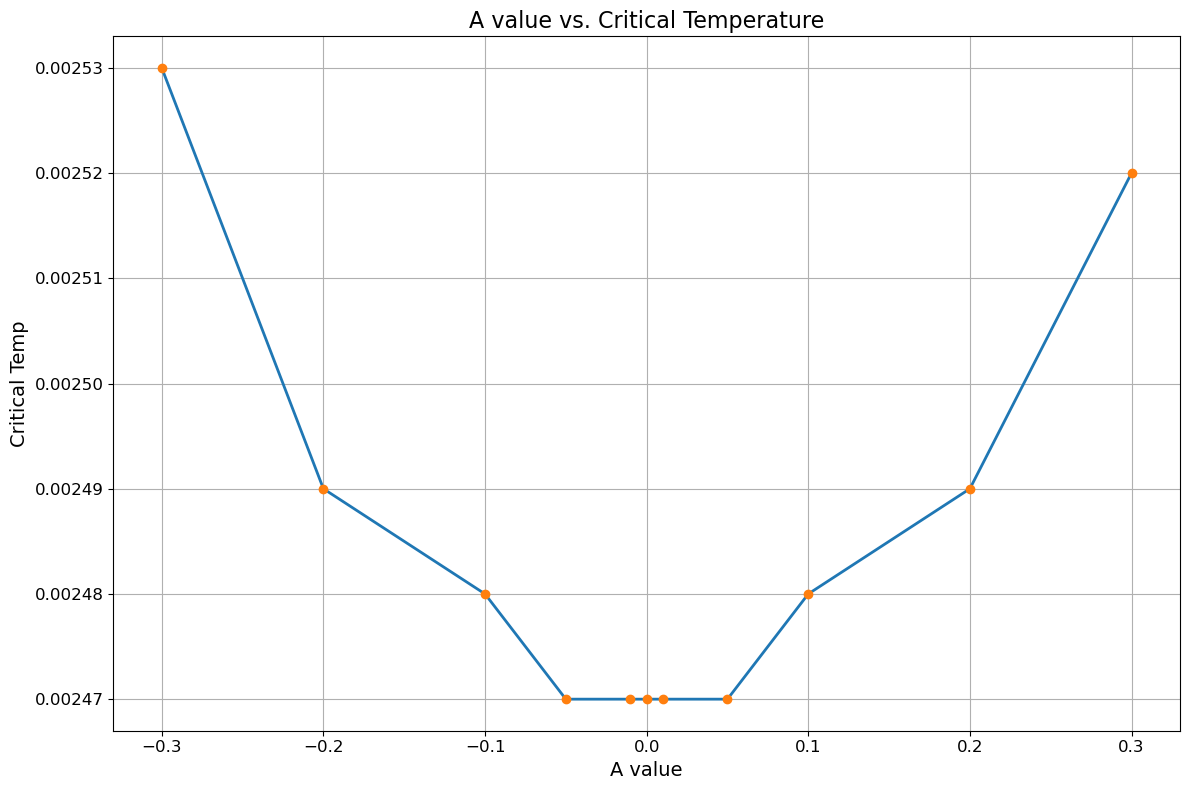

In [11]:
import pandas as pd
closest_eigenvalues = []

for a, data in parent_dict.items():
    # Calculate the absolute difference from 1 for each eigenvalue
    differences = [abs(1 - ev) for ev in data['eigenvalues']]
    
    # Find the index of the eigenvalue with the smallest difference
    min_index = differences.index(min(differences))
    
    # Find the eigenvalue and temperature closest to 1
    closest_eigenvalue = data['eigenvalues'][min_index]
    closest_temperature = data['T_values'][min_index]
    
    # Append the results to the list
    closest_eigenvalues.append((a, closest_temperature, closest_eigenvalue))

# Sort the list by temperature (second item in the tuple)
closest_eigenvalues.sort(key=lambda x: x[1])

df = pd.DataFrame(closest_eigenvalues, columns=['a', 'Temp', 'eigenvalue'])
df = df.sort_values(by=['a'])
# Set up the plot with a larger figure size
plt.figure(figsize=(12, 8))

plt.plot(df['a'], df['Temp'], linewidth=2)
plt.plot(df['a'], df['Temp'], 'o')

# Adding labels with larger font size for clarity
plt.xlabel('A value', fontsize=14)
plt.ylabel('Critical Temp', fontsize=14)

# Adding a title with a larger font size
plt.title('A value vs. Critical Temperature', fontsize=16)

# Adding a grid for better readability
plt.grid(True)

# Increasing tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot with adjustments
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [15]:
# Assuming parent_dict is structured as before
closest_eigenvalues = []

for a, data in parent_dict.items():
    # Calculate the absolute difference from 1 for each eigenvalue
    differences = [abs(1 - ev) for ev in data['eigenvalues']]
    
    # Find the index of the eigenvalue with the smallest difference
    min_index = differences.index(min(differences))
    
    # Find the eigenvalue and temperature closest to 1
    closest_eigenvalue = data['eigenvalues'][min_index]
    closest_temperature = data['T_values'][min_index]
    
    # Append the results to the list
    closest_eigenvalues.append((a, closest_temperature, closest_eigenvalue))

# Sort the list by temperature (second item in the tuple)
closest_eigenvalues.sort(key=lambda x: x[1])

# Print the sorted values
for a, T, eigenvalue in closest_eigenvalues:
    print(f"'a' = {a}: Closest eigenvalue to 1 is {eigenvalue} at T = {T}")


'a' = -0.05: Closest eigenvalue to 1 is 1.0001101445949119 at T = 0.0024700000000000004
'a' = -0.01: Closest eigenvalue to 1 is 0.9999040084501152 at T = 0.0024700000000000004
'a' = 0.0: Closest eigenvalue to 1 is 0.9998954556128735 at T = 0.0024700000000000004
'a' = 0.01: Closest eigenvalue to 1 is 0.9999039916212732 at T = 0.0024700000000000004
'a' = 0.05: Closest eigenvalue to 1 is 1.0001080404928007 at T = 0.0024700000000000004
'a' = -0.1: Closest eigenvalue to 1 is 0.9993545779654388 at T = 0.0024800000000000004
'a' = 0.1: Closest eigenvalue to 1 is 0.999337755008415 at T = 0.0024800000000000004
'a' = -0.2: Closest eigenvalue to 1 is 1.000578113766409 at T = 0.0024900000000000005
'a' = 0.2: Closest eigenvalue to 1 is 1.0004432738559894 at T = 0.0024900000000000005
'a' = 0.3: Closest eigenvalue to 1 is 1.0003831214127055 at T = 0.0025200000000000005
'a' = -0.3: Closest eigenvalue to 1 is 0.9994533701427621 at T = 0.0025300000000000006


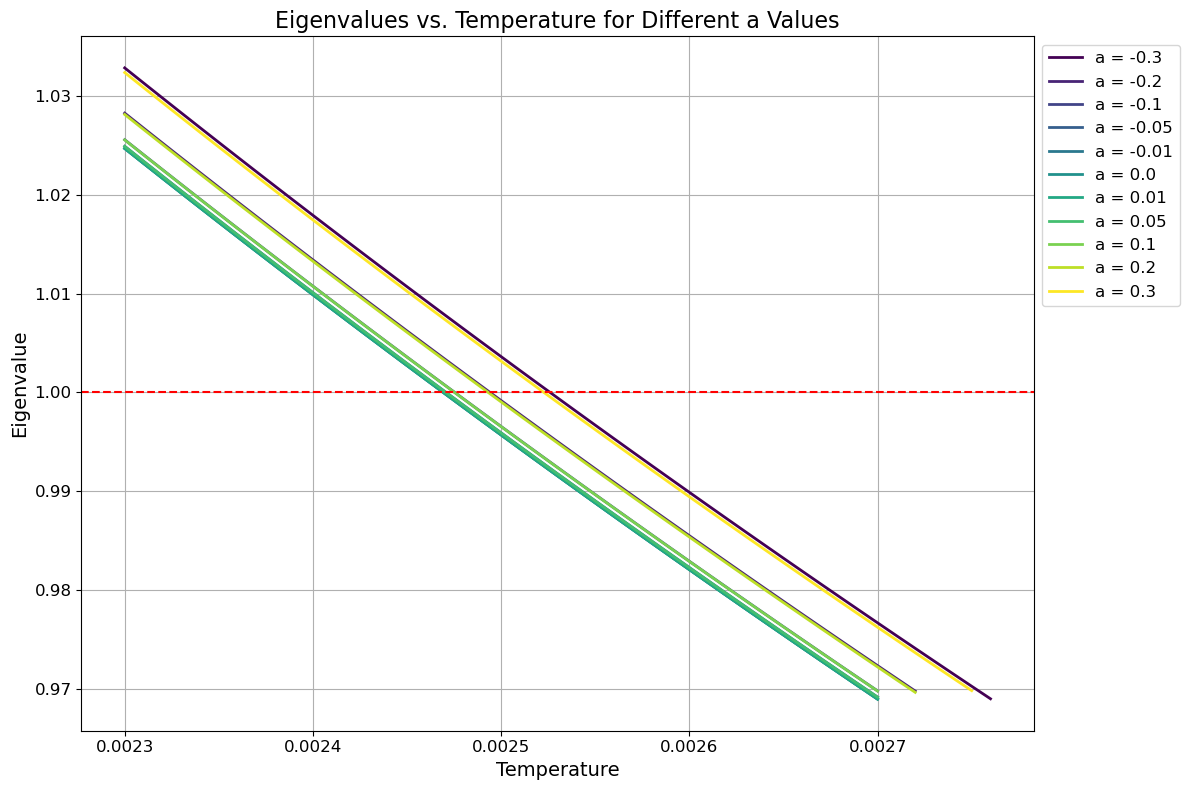

In [12]:
# Set up the plot with a larger figure size
plt.figure(figsize=(12, 8))

# Generate a color map or a list of distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(parent_dict)))

# Plot each line with a unique color and label
for (a, data), color in zip(parent_dict.items(), colors):
    plt.plot(data['T_values'], data['eigenvalues'], label=f'a = {a}', linewidth=2, color=color)

# Adding labels with larger font size for clarity
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)

# Adding a title with a larger font size
plt.title('Eigenvalues vs. Temperature for Different a Values', fontsize=16)

# Adding a grid for better readability
plt.grid(True)

# Increasing tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axhline(y=1.0, color='r', linestyle='--')

# Adding a legend outside the plot area to prevent it from covering the data
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Optionally, set a limit for the Y-axis to zoom in on areas of interest
#plt.ylim([0.9, 1.1])

# Show the plot with adjustments
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()
